In [2]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt


import rl_utils

In [3]:
class ReplayBuffer:
    ''' 
    经验回放池 
    '''
    
    def __init__(self, capacity):
        """
        初始化
        capacity：经验回放池容量
        """
        
        # 队列,先进先出
        self.buffer = collections.deque(maxlen=capacity)  

    def add(self, state, action, reward, next_state, done):  
        """
        将数据加入buffer
        state, action, reward, next_state, done
        (s, a, r, s', done)
        """
        
        # 加入回放池
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  
        """
        从buffer中采样数据,数量为 batch_size
        """
        
        # 采样 batch_size
        transitions = random.sample(self.buffer, batch_size)
        
        # 将各个元素打包到一起，(s, a, r, s', done)
        state, action, reward, next_state, done = zip(*transitions)
        
        # 返回，其中 state 需要转化成 np.array 方便后续输入神经网路
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  
        """
        目前buffer中数据的数量
        """
        return len(self.buffer)

In [4]:
class Qnet(torch.nn.Module):
    ''' 
    只有一层隐藏层的Q网络 
    '''
    
    def __init__(self, state_dim, hidden_dim, action_dim):
        """
        初始化
        state_dim: the dimension of the input state
        hidden_dim: the number of units in the hidden layer
        action_dim: the number of possible actions
        """
        
        # 调用父类的初始化方法
        super(Qnet, self).__init__()
        
        # 输入层到隐藏层
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        
        # 隐藏层到输出层
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        """
        前向传播
        """
        
        # 隐藏层使用ReLU激活函数
        x = F.relu(self.fc1(x))  
        
        return self.fc2(x)

In [5]:
class DQN:
    ''' 
    DQN算法 
    
    '''
    
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        """
        初始化
        state_dim, 状态维度
        hidden_dim, 隐藏层维度
        action_dim, 动作维度
        learning_rate, 学习率
        gamma, 折扣因子
        epsilon, e-greedy 概率参数
        target_update, 目标网络更新频率
        device, pytorch 设备 CPU/GPU
        
        """
        
        # 初始化Q网络
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  
        
        # 初始化目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        
        # 初始化其余参数
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  
        """
        e-greedy 动作策略，基于Q网络
        """
        
        # <e，随机选择一个动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
            
        # >e，通过Q网络基于当前状态计算出动作的概率，选择概率最大的动作
        else:
            # state as torch tensor
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            
            # get max action from Q net
            action = self.q_net(state).argmax().item()
        
        return action

    def update(self, transition_dict):
        """
        训练更新DQN参数：
        通过Q网络获得当前状态的动作价值 q_values
        通过目标网络获得下一状态的动作价值 max_next_q_values
        通过当前状态的奖励和下一状态的动作价值获得TD目标价值 q_targets
        两者误差为TD误差 q_values - q_targets
        
        transition_dict：['states', 'actions', 'rewards', 'next_states', 'dones']
        """
        
        # get elements from transition_dict
        # 注意，这里的状态、动作等元素是一个批次的数据
        # .view(-1, 1): reshapes the tensor to have a single column
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], 
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        # 根据states和当前的Ｑ网络，生成每个状态下，各个动作的概率
        # 通过.gather收集states通过Q网络得到的对应的动作的概率，即Q值
        q_values = self.q_net(states).gather(1, actions)  
        
        # 下个状态的最大Q值
        # 通过目标网络target_q_net得到下一个状态的最大Q值
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        
        # TD误差目标，即当前状态的奖励+下一状态通过目标网络获得的Q值*折扣因子
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        
        # 均方误差损失函数
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        
        # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        self.optimizer.zero_grad()  
        
        # 反向传播更新参数
        dqn_loss.backward()
        
        # 迭代优化器
        self.optimizer.step()

        # 按照间隔 target_update 更新目标网络
        if self.count % self.target_update == 0:
            # 这里简单的将Q网络的参数赋予目标网络
            self.target_q_net.load_state_dict(self.q_net.state_dict())  
            
        
        # 更新训练计数器
        self.count += 1

In [6]:
# 学习率
lr = 2e-3
# 训练轮数
num_episodes = 500
# 隐藏层维度
hidden_dim = 128
# 折扣因子
gamma = 0.98
# e-greedy 概率参数
epsilon = 0.01
# 目标网络更新间隔轮数
target_update = 10
# 经验回放池大小
buffer_size = 10000
# 经验回放池最小size
minimal_size = 500
# 批次大小
batch_size = 64
# device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# 初始化环境
env_name = 'CartPole-v0'
env = gym.make(env_name)

# 随机数
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)

# 经验回放池
replay_buffer = ReplayBuffer(buffer_size)

# 创建DQN智能体
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

# 初始化回报列表，开始训练
# 使用tqdm显示进度条
return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        
        # 开始训练轮数
        for i_episode in range(int(num_episodes / 10)):
            # 初始化当前轮次
            episode_return = 0
            state = env.reset()
            done = False
            
            while not done:
                # 选择动作
                action = agent.take_action(state)
                
                # 执行动作
                next_state, reward, done, _ = env.step(action)
                
                # 加入经验回放池
                replay_buffer.add(state, action, reward, next_state, done)
                
                # 更新状态
                state = next_state
                
                # 累计奖励
                episode_return += reward
                
                # 当经验回放池数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    # 采样批次
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    
                    # 更新智能体DQN中的Q网络与目标网络
                    agent.update(transition_dict)
                    
            # 记录本轮回报
            return_list.append(episode_return)
            
            # 打印进度条
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

# Iteration 0: 100%|██████████| 50/50 [00:00<00:00, 764.86it/s, episode=50,
# return=9.300]
# Iteration 1: 100%|██████████| 50/50 [00:04<00:00, 10.66it/s, episode=100,
# return=12.300]
# Iteration 2: 100%|██████████| 50/50 [00:24<00:00,  2.05it/s, episode=150,
# return=123.000]
# Iteration 3: 100%|██████████| 50/50 [01:25<00:00,  1.71s/it, episode=200,
# return=153.600]
# Iteration 4: 100%|██████████| 50/50 [01:30<00:00,  1.80s/it, episode=250,
# return=180.500]
# Iteration 5: 100%|██████████| 50/50 [01:24<00:00,  1.68s/it, episode=300,
# return=185.000]
# Iteration 6: 100%|██████████| 50/50 [01:32<00:00,  1.85s/it, episode=350,
# return=193.900]
# Iteration 7: 100%|██████████| 50/50 [01:31<00:00,  1.84s/it, episode=400,
# return=196.600]
# Iteration 8: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it, episode=450,
# return=193.800]
# Iteration 9: 100%|██████████| 50/50 [01:34<00:00,  1.88s/it, episode=500,
# return=200.000]

/home/shan/App/miniconda3/envs/isaac_gym/lib/python3.7/site-packages/gym/envs/registration.py:506: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  f"The environment {path} is out of date. You should consider "
/home/shan/App/miniconda3/envs/isaac_gym/lib/python3.7/site-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "
Iteration 9: 100%|██████████████████████| 50/50 [00:17<00:00,  2.93it/s, episode=500, return=200.000]


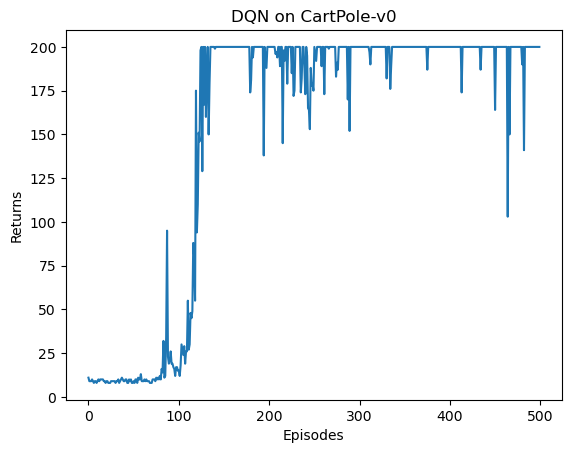

np.insert(a, 0, 0):  [  0.  11.   9.   9.   9.  10.   9.   8.   9.   9.   8.   9.  10.   9.
  10.  10.  10.  10.   9.   9.   8.   9.   9.   8.   8.   8.   9.   9.
   9.   9.   9.   8.   9.   9.  10.   8.   9.  10.  11.  10.   9.   9.
  10.  10.   8.   8.  10.   9.  10.   8.   8.   9.   8.  10.  10.   8.
  11.  10.  10.  13.   9.   9.   9.  10.   9.  10.   9.   9.   9.   8.
   8.   8.  10.  10.  10.   9.  11.  10.  11.  10.  12.  10.  16.  14.
  32.  11.  12.  34.  95.  23.  19.  21.  26.  19.  19.  17.  16.  12.
  17.  17.  15.  15.  12.  18.  30.  27.  24.  29.  19.  26.  26.  55.
  27.  30.  48.  45.  49.  88.  80.  55. 175.  94. 110. 151. 146. 198.
 200. 129. 200. 167. 200. 160. 185. 200. 150. 179. 200. 200. 200. 200.
 200. 199. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 174. 181.
 200. 194. 200. 200. 200. 200. 200. 200. 200. 200. 200. 

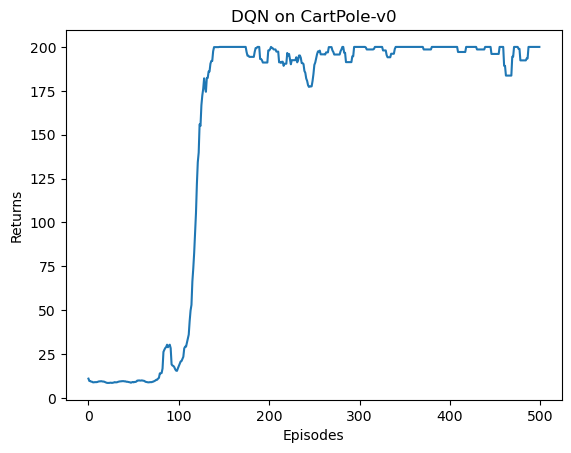

In [7]:
# 训练结果可视化
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

# 移动窗口平均后的训练结果可视化
mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

# DQN 的性能在 100 个序列后很快得到提升，最终收敛到策略的最优回报值 200。
# 我们也可以看到，在 DQN 的性能得到提升后，它会持续出现一定程度的震荡，
# 这主要是神经网络过拟合到一些局部经验数据后由argmax运算带来的影响



In [8]:
class ConvolutionalQnet(torch.nn.Module):
    ''' 
    加入卷积层的Q网络 
    '''
    
    def __init__(self, action_dim, in_channels=4):
        """
        网络结构初始化
        """
        
        # 调用torch.nn.Module的初始化
        super(ConvolutionalQnet, self).__init__()
        
        # 卷积层
        self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        # 全连接层
        self.fc4 = torch.nn.Linear(7 * 7 * 64, 512)
        
        # 输出层
        self.head = torch.nn.Linear(512, action_dim)

    def forward(self, x):
        """
        前向传播
        """
        
        x = x / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x))
        return self.head(x)

In [9]:
import time

while 1:
    action = agent.take_action(state)
    next_state, reward, done, _ = env.step(action)
    env.render()
    time.sleep(0.01)
    if done:
        env.reset()

KeyboardInterrupt: 